With pandas, you'll get the most bang for your buck by *avoiding antipatterns*.
There are additional options like using Numba or Cython if you *really* need to optimize a piece of code, but that's more work typically.

This notebook will walk through several common miskates.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
plt.style.use('default')

## Mistake 1: Using object dtype

Jake VanderPlas has a [great article](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/) on why Python is slow for many of the things we care about as analysts / scientists. As a small demonstration, we'll take two series, one with python integers, and one with NumPy's `int64`.

In [4]:
# Two series of range(10000), different dtypes
s1 = pd.Series(range(10000), dtype=object)
s2 = pd.Series(range(10000), dtype=np.int64)

In [8]:
%timeit s1.sum()

1000 loops, best of 3: 796 µs per loop


In [9]:
%timeit s2.sum()

10000 loops, best of 3: 124 µs per loop


In [17]:
import datetime

In [20]:
import decimal

In [23]:
print(.3 + .3)

0.6


Typically you would never expecitly pass in `dtype=object` there, but occasionally object dtypes slip in

1. Strings

    This is usually unavoidable. Pandas 2.0 will have a specialize string
    time, but for now you're stuck with python objects. If you have few
    *distinct* values (relative to the number of rows), you could use a
    `Categorical`
<br><br>
2. Dates, Times

    Pandas has implemented a specialized verion of `datetime.datime`,
    and `datetime.timedelta`, but not `datetime.date` or `datetime.time`.
<br><br>
3. Decimal types
<br><br>
4. Excel Files
<br><br>
5. Messy CSVs where pandas usual inference fails
<br><br>
6. Integer NA

    Unfortunately, pandas doesn't have real nullable types. To represent
    missingness, pandas uses `NaN` (not a number) which is a special floating point value.

In [29]:
np.nan + 2

nan

In [31]:
s = pd.Series([1, 2, 3, np.nan, 5, 6, 7, 8, 9])
s

0    1.0
1    2.0
2    3.0
3    NaN
4    5.0
5    6.0
6    7.0
7    8.0
8    9.0
dtype: float64

In [30]:
pd.Series([1, 2, 3, np.nan, 5, 6, 7, 8, 9], dtype=object)

0      1
1      2
2      3
3    NaN
4      5
5      6
6      7
7      8
8      9
dtype: object

### Aside: Managing Dtypes

Pandas provides some tools for converting arrays
of strings to their specialized dtype.

0. IO operations (`read_csv` infers, but can use the `dtype` keyword)
1. Object -> numeric: `pd.to_numeric`
2. Object -> datetime: `pd.to_datetime`
3. Object -> timedelta: `pd.to_timedelta`
4. Object -> category: `pd.Categorical`

They're pretty flexible what they accept.

In [49]:
# to_numeric
df = pd.DataFrame(
    {'t': pd.date_range(start='2010-01-01', end='2015-01-01'),
     'offset': pd.timedelta_range(start=0, periods=1827)})

In [44]:
df.t.head()

0   2010-01-01
1   2010-01-02
2   2010-01-03
3   2010-01-04
4   2010-01-05
Name: t, dtype: datetime64[ns]

In [43]:
df.t.diff()

0         NaT
1      1 days
2      1 days
3      1 days
4      1 days
        ...  
1822   1 days
1823   1 days
1824   1 days
1825   1 days
1826   1 days
Name: t, dtype: timedelta64[ns]

In [61]:
# to_timedelta
x = pd.to_timedelta(['1H', '30s', '20blah'], errors='coerce')
x.seconds

array([ 3600.,    30.,    nan])

In [62]:
pd.to_timedelta(['1H', '30s', '20blah'], errors='ignore').seconds

AttributeError: 'numpy.ndarray' object has no attribute 'seconds'

In [4]:
# to_datetime


## Mistake 2: Initialization

When your collecting many different sources (say a bunch of separate CSVs) into
a single DataFrame, you have two paths to the same goal:

1. Make a single empty DataFrame, append to that
2. Make a list of many DataFrames, concat at end

Typically, in python we'd choose the first one if we were, for example, collecting things into a `list`. `list.append` is very fast. However `DataFrame.append` is *not* fast.

In [ ]:
output = []

for thing in collection:
    result = function(thing)
    output.append(result)

In [ ]:
[function(thing) for thing in collection]

In [63]:
import time

size_per = 5000
N = 100
cols = list('abcd')

def timed(n=30):
    '''
    Just benchmarking
    '''
    def deco(func):
        def wrapper(*args, **kwargs):
            timings = []
            for i in range(n):
                t0 = time.time()
                func(*args, **kwargs)
                t1 = time.time()
                timings.append(t1 - t0)
            return timings
        return wrapper
    return deco

@timed(60)
def append_df():
    '''
    The pythonic (bad) way
    '''
    df = pd.DataFrame(columns=cols)
    for _ in range(N):
        df = df.append(pd.DataFrame(np.random.randn(size_per, 4),
                                    columns=cols),
                       ignore_index=True)
    return df

@timed(60)
def concat_df():
    '''
    The pandorabe (good) way
    '''
    dfs = [pd.DataFrame(np.random.randn(size_per, 4), columns=cols)
           for _ in range(N)]
    return pd.concat(dfs, ignore_index=True)

In [64]:
t_append = append_df()
t_concat = concat_df()

timings = (pd.DataFrame({"Append": t_append, "Concat": t_concat})
             .stack()
             .reset_index()
             .rename(columns={0: 'Time (s)',
                              'level_1': 'Method'}))
timings.head()


,level_0,Method,Time (s)
0,0,Append,0.800021
1,0,Concat,0.124761
2,1,Append,0.758374
3,1,Concat,0.102260
4,2,Append,0.739129


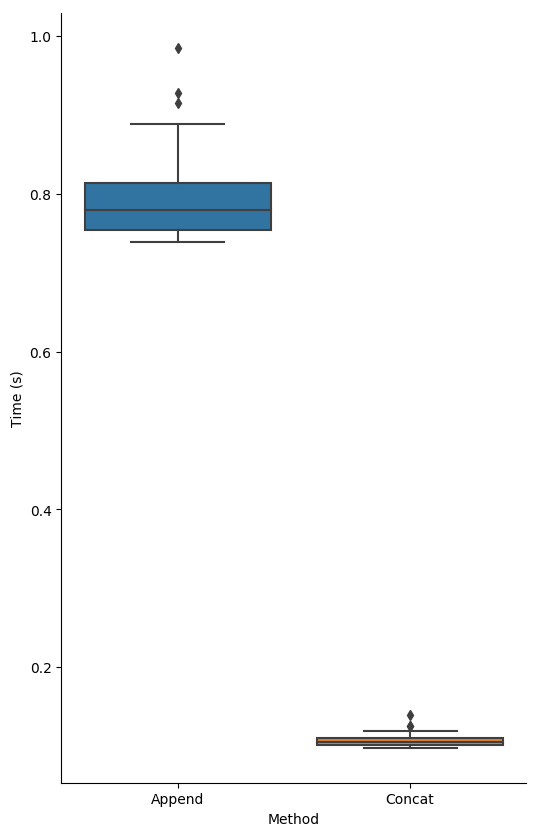

In [65]:
plt.figure(figsize=(6, 10))
sns.boxplot(x='Method', y='Time (s)', data=timings)
sns.despine()
plt.show()

## Mistake 3: Doing too much work

This is more general purpose advice, rather than something you can just grep your code for.

In [68]:
# read in DEP_DELAY column from flights
df = pd.read_csv("data/flights.csv.zip", usecols=['DEP_DELAY'])
delays = df['DEP_DELAY']
delays.head()

0     14.0
1    122.0
2     -3.0
3      2.0
4     -2.0
Name: DEP_DELAY, dtype: float64

Suppose we wanted to the 5 longest delays. One option is to sort the entire Series and then take the head

In [69]:
%timeit delays.sort_values(ascending=False).head(5)

10 loops, best of 3: 59 ms per loop


A better option is to use the `nlargest` method on `Series`, and then sort just those 5 elements.

In [70]:
%timeit delays.nlargest(5).sort_values(ascending=False)

100 loops, best of 3: 11.1 ms per loop


Other examples include using [KDTrees](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) instead of finding all pairwise distances, various [probabilistic algorithms](https://github.com/ekzhu/datasketch).

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the nearest neighbor for all the airports with at least 500 departures.

The naïve way to do this is to compute a pairwise distance matrix of all 500 airports, and then lookup the closest neighbor for each airport.

Let's avoid that unnescessary computation by using a `KDTree`.

In [73]:
coord = pd.read_csv("data/flights_coord.csv")
coord.head()

,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_STATE_CODE,LATITUDE,LONGITUDE,Unnamed: 6
0,10001,01A,"Afognak Lake, AK",AK,58.109444,-152.906667,NaN
1,10003,03A,"Granite Mountain, AK",AK,65.548056,-161.071667,NaN
2,10004,04A,"Lik, AK",AK,68.083333,-163.166667,NaN
3,10005,05A,"Little Squaw, AK",AK,67.570000,-148.183889,NaN
4,10006,06A,"Kizhuyak, AK",AK,57.745278,-152.882778,NaN


Step 1: Create a variable `ids` that is a `pd.Index` with just the `ORIGIN_AIRPORT_ID` with at leasts 500 departures.

In [77]:
flights = pd.read_csv("data/flights.csv.zip")
vc = flights.ORIGIN_AIRPORT_ID.value_counts()
ids = vc.index[vc >= 500]
ids

Int64Index([10397, 11298, 13930, 12892, 11292, 12266, 14771, 14107, 12889,
            11057,
            ...
            14783, 13296, 15096, 12217, 10874, 14685, 12896, 11140, 12402,
            12951],
           dtype='int64', length=114)

In [ ]:
# %load solutions/performance_00.py
ids = flights.ORIGIN_AIRPORT_ID.value_counts()
ids = ids[ids >= 500].index
ids


Step 2: Filter `coord` to just those rows where `AIRPORT_ID` is in `ids`.

In [79]:
subset = coord[coord.AIRPORT_ID.isin(ids)]
subset.head()

,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_STATE_CODE,LATITUDE,LONGITUDE,Unnamed: 6
170,10140,ABQ,"Albuquerque, NM",NM,35.041667,-106.606389,NaN
171,10140,ABQ,"Albuquerque, NM",NM,35.040278,-106.609167,NaN
172,10140,ABQ,"Albuquerque, NM",NM,35.038889,-106.608333,NaN
429,10257,ALB,"Albany, NY",NY,42.745833,-73.805278,NaN
430,10257,ALB,"Albany, NY",NY,42.749167,-73.801944,NaN


In [ ]:

%load solutions/performance_01.py

Not sure why, but apparently they might have multiple lat/lngs for an airport.
We'll aggregate and grab the first.
We haven't done groupby yet, so I'll write this one out.

In [80]:
locs = subset.groupby('AIRPORT')[['LONGITUDE', 'LATITUDE']].first()
locs.head()

,LONGITUDE,LATITUDE
AIRPORT,,
ABQ,-106.606389,35.041667
ALB,-73.805278,42.745833
AMA,-101.721944,35.227222
ANC,-149.985278,61.169167
ASE,-106.868889,39.224167


We'll also make a mapping between the airport IDs and names for later.

In [81]:
names = subset.groupby('AIRPORT_ID').AIRPORT.first()
names.head()

AIRPORT_ID
10140    ABQ
10257    ALB
10279    AMA
10299    ANC
10372    ASE
Name: AIRPORT, dtype: object

Step 3: Use [`sklearn.neighbors.KDTree`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) to find the nearest neighbors. If you haven't used scikit-learn before, I've provided stubs of a solution below.

In [83]:
locs

,LONGITUDE,LATITUDE
AIRPORT,,
ABQ,-106.606389,35.041667
ALB,-73.805278,42.745833
AMA,-101.721944,35.227222
ANC,-149.985278,61.169167
ASE,-106.868889,39.224167
...,...,...
TPA,-82.535278,27.973056
TUL,-95.889722,36.197778
TUS,-110.940556,32.116111


In [96]:
from sklearn.neighbors import KDTree

# the result of KDTree.query is a list of index
# *positions*, we'll use id_map to go from 
# positions back to airport names
id_map = dict(enumerate(locs.index))

tree = KDTree(locs)

# Now use `tree.query` to find the distances and
# nearest neighbor. Make sure to a NumPy array to `.query`
# and not a DataFrame; otherwise it gets confused.
# How many neighbors (k=...) do we need?
distances, indexes = tree.query(locs.values, k=2)

# # slice the NumPy arrays to just what we need
indexes = indexes[:, 1]
distances = distances[:, 1]
neighbors = pd.Series(indexes, index=locs.index).map(id_map)
neighbors.head()

AIRPORT
ABQ    ELP
ALB    BDL
AMA    LBB
ANC    SEA
ASE    DEN
dtype: object

In [ ]:
# %load solutions/performance_02.py
from sklearn.neighbors import KDTree

# the result of KDTree.query is a list of index
# *positions*, we'll use id_map to go from
# positions back to airport names
id_map = dict(enumerate(locs.index))

tree = KDTree(locs)

distances, indexes = tree.query(locs.values, k=2)
indexes = indexes[:, 1]
distances = distances[:, 1]
neighbors = pd.Series(indexes, index=locs.index).map(id_map)
neighbors.head()


## Using `.apply` (with axis=1) (Avoid Iteration)

I see this one a lot. I don't like absolutes, but you should never use `.apply(..., axis=1)` (probably).

Brief aside on survival analysis: Want to estimate the future lifetime value of a customer using historical data:

In [142]:
a = [1, 2, 3, 4, 5, 6]
b = [1, 2, 3, 4, 5, 6]

[xa + xb for (xa, xb) in zip(a, b)]

[2, 4, 6, 8, 10, 12]

In [112]:
%timeit [xa + xb for (xa, xb) in zip(a, b)]

1000000 loops, best of 3: 1.21 µs per loop


In [140]:
a + b

array([ 3.4257489,  4.4257489])

In [139]:
npa  = np.array(a)
npb  = np.array(b)

In [113]:
%timeit npa + npb

The slowest run took 22.26 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 596 ns per loop


In [116]:
np.sqrt(npa)

array([ 1.        ,  1.41421356,  1.73205081,  2.        ,  2.23606798,
        2.44948974])

In [117]:
np.exp(npa)

array([   2.71828183,    7.3890561 ,   20.08553692,   54.59815003,
        148.4131591 ,  403.42879349])

In [ ]:
!pip install lifetimes

In [120]:
from lifetimes.datasets import load_cdnow
from lifetimes import BetaGeoFitter

data = load_cdnow(index_col=[0])

data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


These are all customer-level statistics:

- frequency: number of repeat purchases
- T: "age" of the customer (units since first purchase)
- recency: age at time of last purchase

The `lifetimes.BetaGeoFitter` model has a scikit-learn-like API to estimate several parameters and has several utility methods.

In [122]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

/Users/tom.augspurger/miniconda3/envs/uni/lib/python3.5/site-packages/lifetimes/estimation.py:557: RuntimeWarning: invalid value encountered in log
  A_4 = log(a) - log(b + freq - 1) - (r + freq) * log(rec + alpha)


<lifetimes.BetaGeoFitter: fitted with 2357 subjects, r: 0.24, alpha: 4.41, a: 0.79, b: 2.43>

In [123]:
plt.style.use('default')

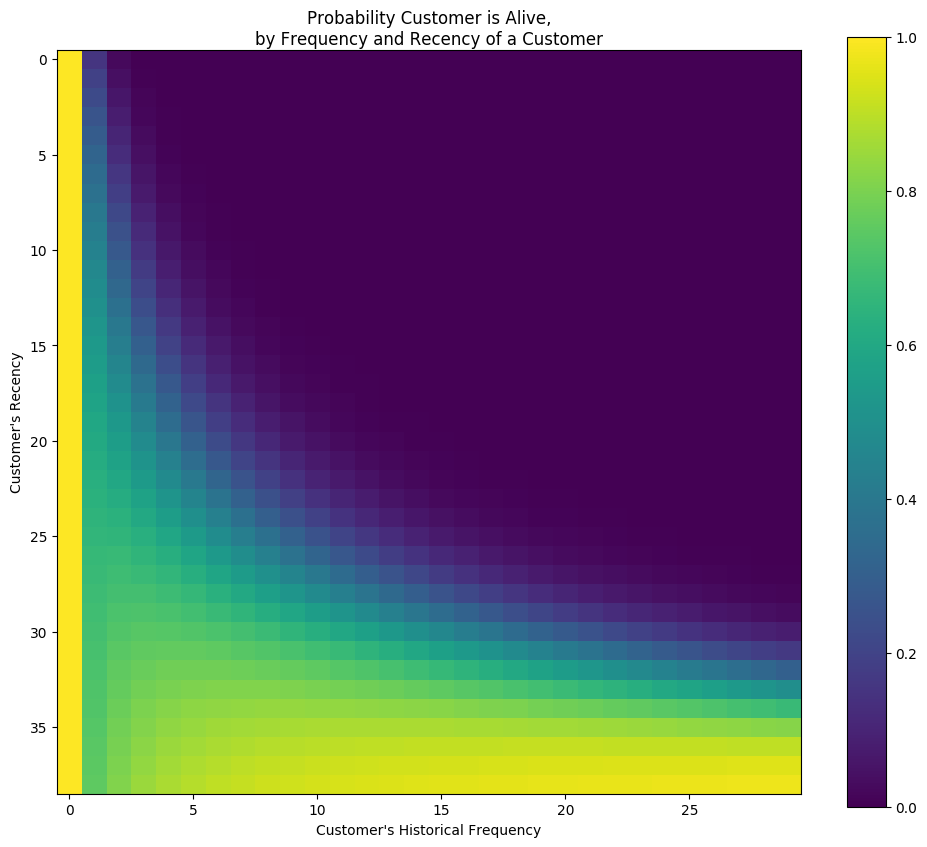

In [124]:
from lifetimes.plotting import plot_probability_alive_matrix
plt.figure(figsize=(12, 10))
plot_probability_alive_matrix(bgf, cmap='viridis');

[Apparently](http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf), we can calculate the expected number of purchases over the next $t$ periods with

\begin{align*}
    E\left(X(t) \vert \lambda, p\right) &= \lambda t \cdot P(\tau > t) + \int_0^t \lambda \tau g(\tau \vert \lambda, p)  \tau \\
    &= \frac{1}{p} - \frac{1}{p} e^{-\lambda pt}
\end{align*}

With some fancy math and substitutions, the following calculation does that.

In [146]:
from scipy import special

r, α, a, b = bgf._unload_params('r', 'alpha', 'a', 'b')
print(r, α, a, b)

def conditional_n_purchases(t, frequency, recency, T):
    x = frequency

    hyp_term = special.hyp2f1(r + x, b + x, a + b + x - 1, t / (α + T + t))
    first_term = (a + b + x - 1) / (a - 1)
    second_term = (1 - hyp_term * ((α + T) / (α + t + T)) ** (r + x))
    numerator = first_term * second_term

    denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((α + T) / (α + recency)) ** (r + x)

    return numerator / denominator

0.242592193449 4.41351013066 0.792882462085 2.425748904


In [127]:
data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


In [129]:
conditional_n_purchases(t=5, frequency=2, recency=30.43, T=38.86)

0.18315778518325104

Originally, `lifetimes`' documentation had code similar to the following:

In [132]:
data.apply(lambda row: conditional_n_purchases(5,
                                               row['frequency'],
                                               row['recency'],
                                               row['T']),
           axis=1)

ID
1       0.183158
2       0.029759
3       0.027552
4       0.027552
5       0.027552
          ...   
2353    0.037717
2354    0.665434
2355    0.037717
2356    0.559680
2357    0.037717
dtype: float64

In [131]:
%%timeit
t = 5
# Using .apply(λ row:, axis=1)
data.apply(lambda row: conditional_n_purchases(5,
                                               row['frequency'],
                                               row['recency'],
                                               row['T']),
           axis=1)

10 loops, best of 3: 146 ms per loop


You almost never want to use `.apply` with axis=1. `.apply`

- A bunch of type inference
- Some "helpful" reductions of output shape
- Is essentially a for loop internally

If you *insist* on looping, use `.itertuples` which returns an iterator of `namedtuples`.

In [136]:
from collections import namedtuple

In [135]:
next(data.itertuples())

Pandas(Index=1, frequency=2, recency=30.43, T=38.859999999999999)

In [133]:
%%timeit
t = 5
pd.Series([
    conditional_n_purchases(5, row.frequency, row.recency, row.T)
    for row in data.itertuples()
])

10 loops, best of 3: 28.9 ms per loop


But we can do even better.

In [148]:
data['frequency']

ID
1       2
2       1
3       0
4       0
5       0
       ..
2353    0
2354    5
2355    0
2356    4
2357    0
Name: frequency, dtype: int64

In [150]:
%%timeit
t = 5
# Using vectorization
conditional_n_purchases(5, data['frequency'], data['recency'], data['T'])

100 loops, best of 3: 3.59 ms per loop


It's quite natural to say "I have this complicated function `f` to apply to each 
row, I'll just just use `.apply(f, axis=1)`". Avoid that temptation.

# I/O

This is a tricky subject to say too much about since so much else goes into the decision of what IO system to use

- Do you "own" the data, or are you part of a larger system? Do you even have a choice?
- Do you need compatability with other systems?
- What types of data are you storing?

That said, some general observations

- `read_csv` is fast as far as CSV parsers go, but CSVs are *lossy* and inefficient
- `to_csv` is pretty slow (unoptimized)
- `to_sql` is *very* slow; most relational databases have dedicated methods for loading large volumes of data
- `read_json` / `to_json` are both implemented in C and fast
- `read_hdf` / `to_hdf` are both *very* fast thanks to `libhdf`, but are not threadsafe for reading or writing; The `format='table'` can perfectly represent a pandas DataFrame, but are not portable;
- `feather` is very fast, portable, but young. Might get a `to_feather` / `read_feather` in 0.19.1 or 0.20.0